In [1]:
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [13]:
cities = pd.read_csv('data/Top50/top50cities.csv',delimiter=',')
cities

,Unnamed: 0,name,population,lat,lng,countryId,countryName,countryCode,fclName,geonameId
0,0,Moscow,10381222,55.75222,37.61556,2017370,Russia,RU,"city, village,...",524901
1,1,London,7556900,51.50853,-0.12574,2635167,United Kingdom,GB,"city, village,...",2643743
2,2,St Petersburg,5028000,59.93863,30.31413,2017370,Russia,RU,"city, village,...",498817
3,3,Berlin,3426354,52.52437,13.41053,2921044,Germany,DE,"city, village,...",2950159
4,4,Madrid,3255944,40.41650,-3.70256,2510769,Spain,ES,"city, village,...",3117735
5,5,Rome,2318895,41.89193,12.51133,3175395,Italy,IT,"city, village,...",3169070
6,6,Kyiv,2797553,50.45466,30.52380,690791,Ukraine,UA,"city, village,...",703448
7,7,Paris,2138551,48.85341,2.34880,3017382,France,FR,"city, village,...",2988507
8,8,Bucharest,1877155,44.43225,26.10626,798549,Romania,RO,"city, village,...",683506
9,9,Budapest,1741041,47.49801,19.03991,719819,Hungary,HU,"city, village,...",3054643


In [ ]:
#import nodes to get id from nodes/hosts
hosts = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    for p in range(1,14):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv',index_col=False)
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
print(len(hosts))
hosts=hosts.drop_duplicates()
print(len(hosts))


In [57]:
hosts['lat']='NaN'
hosts['lng']='NaN'
#rev['city']='NaN'
hosts['country']='NaN'
for idx,city in cities.iterrows():
    l = hosts.loc[hosts.city==city['name'].lower()].index.tolist()
    for i in l:
        hosts.set_value(i,'lat',city['lat'])
        hosts.set_value(i,'lng',city['lng'])
        hosts.set_value(i,'city',city['name'].lower())
        hosts.set_value(i,'country',city['countryCode'].lower())
len(hosts.values)

/Users/Eike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Eike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/Eike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/Users/Eike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


10582

In [51]:
rev= pd.read_csv('data/reviews_total_geo_2.csv')

/Users/Eike/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,7,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
#drop entries that couldn't be found in the preprocessing part
print(len(rev))
rev=rev[pd.to_numeric(rev['lat'], errors='coerce').notnull()]
print(len(rev))

96085
95270


In [82]:
G = nx.MultiDiGraph()
#Add hosts to the network
G.add_nodes_from([(rows['id'],{'city':rows['city'],'lat':rows['lat'],'lng':rows['lng']}) for idx,rows in hosts.iterrows()])
#Add users to the network from the source reviews/surfers and hosts
G.add_nodes_from([(rows['from'],{'city':rows['city'],'lat':rows['lat'],'lng':rows['lng']}) for idx,rows in rev.iterrows()])


In [94]:

nodes = list(G.nodes())
'2009059021' in str(nodes)

True

In [97]:
G.remove_edges_from(list(G.edges()))
nodes = list(G.nodes())
nodes = str(nodes)
for idx,r in useableRev.iterrows():
    if r['from'] in nodes and r['to'] in nodes:
        if r['relationshipType']=='surf':
            G.add_edge(r['from'],r['to'])
        if r['relationshipType']=='host':
            G.add_edge(r['to'],r['from'])
    else:
        print(r['from'],r['to'])


TypeError: 'in <string>' requires string as left operand, not int

In [67]:
G.edges()

OutMultiEdgeDataView([(2003698502, 2004079282), (2003698502, 1001118581), (2005423146, 3408547), (4935233, 2000928283), (2006551502, 1003073305), (3763561, 4851533), (2007673273, 2003760110), (2006292031, 1006862923), (4837184, 2008030003), (4837184, 3000011), (2003524112, 2006005134), (5440080, 2005595425), (2003425140, 2001524543), (2004297332, 2003234067), (2002955433, 2008149808), (2002955433, 2006385338), (2003925874, 4741042), (2000986491, 2004167903), (3062982, 2007838968), (1994736, 2785626), (1994736, 1879329), (2521265, 1005779213), (2005626227, 2006028050), (2005626227, 3152138), (2005626227, 5128240), (2006418357, 2004343858), (2006418357, 2470879), (2000636767, 2005036598), (2696162, 1531017), (2696162, 2002528744), (2008409687, 2006888174), (2284225, 1307671), (2284225, 2008126716), (1003421302, 2005842132), (3734254, 2676148), (1000153053, 1000839072), (1000153053, 2008384074), (1000153053, 310310), (1000153053, 2003051934), (1757898, 1000835516), (3109052, 3013467), (20

In [76]:
#pos = {x[0]:(x[1]['lat'], x[1]['lng']) for x in list(G.nodes(data=True))}
#pos
list(G.nodes())

[2009059021,
 2008295707,
 2009276730,
 2007438797,
 2009017440,
 2008873184,
 2003698502,
 2005423146,
 2008461429,
 2007897688,
 1005318661,
 2002963430,
 2007156292,
 2007603705,
 2008732238,
 2008182963,
 1000754645,
 2003021439,
 4308983,
 3531747,
 2000411067,
 2000854741,
 2008478484,
 2009179593,
 2009063624,
 2007416721,
 4935233,
 2005146189,
 2007169164,
 4196062,
 2008850446,
 2008606300,
 2006253648,
 2006551502,
 2006558767,
 3918396,
 2004462182,
 2002472636,
 2007594801,
 2001266184,
 1002168816,
 2004013575,
 2001824984,
 2001725408,
 5491042,
 1219678,
 3763561,
 2008014491,
 2000196295,
 2005517106,
 2007673273,
 214516,
 1004228730,
 2006292031,
 4837184,
 2009339054,
 2003524112,
 1005272382,
 4423503,
 2008001548,
 2005267821,
 1005685083,
 2008914962,
 2007963792,
 1004879916,
 2008144376,
 2000725799,
 2008580609,
 1006347777,
 2002969804,
 1003847636,
 1003833208,
 2007840041,
 5489152,
 3311709,
 2002741048,
 2003995334,
 2008252902,
 2553856,
 5440080,
 10028

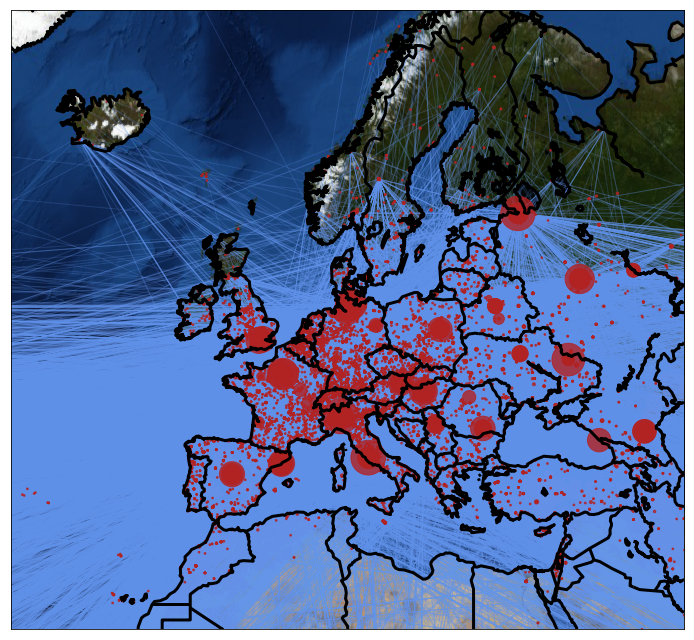

In [77]:
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-30,llcrnrlat=25,urcrnrlon=50,
urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
#mx, my = m(cities['lng'].values, cities['lat'].values)
mx,my = m(list(nx.get_node_attributes(G,'lng').values()),list(nx.get_node_attributes(G,'lat').values()))
pos = {}
for count, elem in enumerate(list(G.nodes())):
     pos[elem] = (mx[count], my[count])

nx.draw_networkx_nodes(G, pos = pos, node_list =G.nodes() ,node_color = 'firebrick', alpha = 0.8, node_size = [v[1] * 3 for v in G.degree()])
nx.draw_networkx_edges(G, pos = pos, edge_color='cornflowerblue', alpha=0.2, arrows = False)
#nx.draw_networkx_edges(G, pos = pos, edge_color='g', alpha=0.2, arrows = False)
m.drawcountries(linewidth = 3)
#m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
m.bluemarble()
plt.tight_layout()
#plt.savefig("map.png", format = "png", dpi = 300)

plt.show()

In [58]:
#user_id_unique=set(hosts['id'].tolist())
#G.add_nodes_from([(rows['name'],{'lat':rows['lat'],'lng':rows['lng']}) for idx,rows in cities.iterrows()])
#G.add_nodes_from([(rows['fromPublicAddressDescription'],{'lat':rows['lat'],'lng':rows['lng']}) for idx,rows in rev.iterrows() if rows['lat'] !='NaN' and rows['lng']!='NaN'])
#for idx,r in rev.iterrows():
    #if r['from'] in hosts['id'].tolist() and r['to'] in hosts['id'].tolist():
    #if r['from'] in list(G.nodes()):
    #    if r['relationshipType']=='surf':
    #        #G.add_edge(hosts.loc[hosts['id']==r['from']]['city'].item(),hosts.loc[hosts['id']==r['to']]['city'].item())
    #        G.add_edge()
    #    if r['relationshipType']=='host':
    #        G.add_edge(hosts.loc[hosts['id']==r['to']]['city'].item(),hosts.loc[hosts['id']==r['from']]['city'].item())
#G.add_edges_from([(rows['to'],rows['from'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='host' and G.has_node(rows['to']) and G.has_node(rows['from'])])
#G.add_edges_from([(rows['from'],rows['to'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='surf' and G.has_node(rows['to']) and G.has_node(rows['from'])])

2001999679
rev

,id,text,createdDate,experience,relationshipType,isPostTrip,to,from,fromPublicName,fromPublicAddressId,...,fromStatus,fromIsVerified,fromIsDeleted,fromBlockedBy,inverseReference,response,lat,lng,city,country
0,27077307,Amazing chef and humble human being. Willing t...,2018-10-17T22:09:22Z,positive,host,True,2009059021,2001999679,Dhanush Anand,109610804.0,...,yes,True,False,NaN,NaN,NaN,3.695000,96.868000,setiabudi,id
1,27152728,Amazing boy with amazing family . He met me up...,2018-10-28T19:16:31Z,positive,surf,True,2009059021,2007724821,Bakhar Sardzhaeva,271153483.0,...,no,False,False,NaN,NaN,NaN,25.258172,55.304717,dubai,ae
2,26922175,￼\n\n \n\nWe use cookies to enhance your exper...,2018-09-27T14:41:06Z,positive,surf,True,2008295707,2008797517,Sun-hyung Kim,312790604.0,...,maybe,False,False,NaN,NaN,NaN,37.598500,126.978300,seoul,kr
3,26866500,"I was ill, when I come to Alexey's place, so I...",2018-09-20T17:32:11Z,positive,surf,True,2008295707,2003041472,Michelle Kuglerová,123277124.0,...,maybe,False,False,NaN,NaN,NaN,49.400000,15.583333,jihlava,cz
4,26818885,Didn't end up staying at his house because of....,2018-09-15T05:17:31Z,positive,surf,True,2008295707,4294146,Yvette Shaw,6999267.0,...,no,False,False,NaN,NaN,NaN,-35.283333,174.083333,paihia,nz
5,26779351,С Алексеем было очень приятно и комфортно пров...,2018-09-10T12:56:37Z,positive,surf,True,2008295707,2008843836,Angelika Krasnozhonova,314663738.0,...,hang,True,False,NaN,NaN,NaN,58.596650,49.660070,"kirov,",ru
6,26176442,I had a great experience in Russia with Alexei...,2018-07-10T13:57:26Z,positive,surf,True,2008295707,2007359140,Diego Gabriel Cortez Fernandez,250795609.0,...,no,False,False,NaN,NaN,NaN,30.293650,120.161419,hangzhou,cn
7,26164016,I bet Alexey is definitely a good person. He l...,2018-07-09T09:52:29Z,positive,surf,True,2008295707,2007634207,Heejeong Yang,265596282.0,...,no,False,False,NaN,NaN,NaN,37.598500,126.978300,seoul,kr
8,26148751,My experience with Alexey was awesome. He is ...,2018-07-07T16:05:53Z,positive,surf,True,2008295707,2005150941,Siboney Godoy,176314139.0,...,hang,False,False,NaN,NaN,NaN,39.290380,-76.612190,"baltimore,",us
9,26119628,Alexey is a really amazing host!! At the first...,2018-07-04T09:15:01Z,positive,surf,True,2008295707,1003812034,Emma Jimenez,10585071.0,...,maybe,False,False,NaN,NaN,NaN,8.516569,-76.077564,pereira,co


In [59]:
hosts

,id,publicName,avatarUrl,isVerified,status,lastLogin,aboutText,responseRate,responseTimeText,responseRateText,totalReferencesCount,profileLink,friendsCount,languages,city,lat,lng,country
0,2009059021,Alexey Sedov,https://tcdn.couchsurfing.com/gPQnUnQqAzH-QEdh...,True,yes,about 9 hours,Good man,100,replies within a day,100% response rate,4,/people/alexey-sedov,13,{'fluent': []},moscow,55.7522,37.6156,ru
1,2008295707,Alexey Perfilyev,https://tcdn.couchsurfing.com/E46TCOOpAktjGSSN...,True,yes,about 9 hours,"Hi, my name is Alexey. Now I'm an engineer and...",98,replies within 1-3 days,98% response rate,23,/people/alexey_perfilyev,17,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
2,2009276730,George Zheleznyi,https://tcdn.couchsurfing.com/juLx6e9yn3WEMz54...,True,yes,about 3 hours,Currently running a startup in the vegan food ...,-1,replies within a day,-1% response rate,1,/people/george-zheleznyi,5,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
3,2007438797,Sergey Savkin,https://tcdn.couchsurfing.com/v6r0UbCdztArIqUp...,True,yes,about 2 hours,"If you want to stay, please read all about my ...",100,replies within a day,100% response rate,6,/people/sergey-savkin-1,20,"{'fluent': [{'code': 'rus', 'name': 'Russian'}]}",moscow,55.7522,37.6156,ru
4,2009017440,Irina Arhipova,https://tcdn.couchsurfing.com/6bxRtCZTVy06mP7h...,True,yes,13 minutes,"Friends, please attention we are live 6 km fro...",100,replies within a day,100% response rate,5,/users/2009017440,37,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
5,2008873184,Arina Barinova,https://tcdn.couchsurfing.com/3bO1UIJ4i6JpckIS...,True,yes,30 minutes,Hey everyone!)\nI’m a positive person who want...,95,replies within 1-3 days,95% response rate,4,/people/arina-barinova,11,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
6,2003698502,Dmitry Zorin,https://tcdn.couchsurfing.com/mDaphugqZIorzF7_...,True,yes,about 2 hours,CURRENT MISSION\r\n\r\nTo find my truly missio...,92,replies within a day,92% response rate,33,/people/dmitryzorin,57,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
7,2005423146,Anton & Tanya Zhilenko,https://tcdn.couchsurfing.com/Ih8ynFKoFO1Z9kaA...,True,yes,about 8 hours,"My name's Anton, I leave near Moscow, in Koro...",100,replies within a day,100% response rate,16,/people/anton-zhilenko,18,"{'fluent': [{'code': 'rus', 'name': 'Russian'}]}",moscow,55.7522,37.6156,ru
8,2008461429,Sergei Grosov,https://tcdn.couchsurfing.com/0NLw1WG0AhtRfidy...,True,yes,about 2 hours,A bit sportsman and traveller :),100,replies within a day,100% response rate,12,/users/2008461429,21,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
9,2007897688,Diana Pacijevska,https://tcdn.couchsurfing.com/Ic6Sn0Ldme6NBr4b...,True,yes,about 1 hour,"Before you make a request, please, be aware of...",94,replies within 1-3 days,94% response rate,8,/people/diana-pacijevska,7,"{'fluent': [{'code': 'rus', 'name': 'Russian'}...",moscow,55.7522,37.6156,ru
